In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import os

sns.set_style('dark')

FILE = "PGE.csv"
DIRI = "data"
MAX_K = 50

In [2]:
file_path = os.path.join(DIRI, FILE)
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_time             43848 non-null  object
 1   raw demand (MW)       43848 non-null  object
 2   category              43848 non-null  object
 3   cleaned demand (MW)   43848 non-null  int64 
 4   forecast demand (MW)  43848 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [3]:
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW)
0,2015-07-02 00:00:00,MISSING,MISSING,2740,MISSING
1,2015-07-02 01:00:00,MISSING,MISSING,3287,MISSING
2,2015-07-02 02:00:00,MISSING,MISSING,3264,MISSING
3,2015-07-02 03:00:00,MISSING,MISSING,3192,MISSING
4,2015-07-02 04:00:00,MISSING,MISSING,3136,MISSING
...,...,...,...,...,...
43843,2020-07-01 19:00:00,2315,OKAY,2315,2359
43844,2020-07-01 20:00:00,2337,OKAY,2337,2392
43845,2020-07-01 21:00:00,2325,OKAY,2325,2391
43846,2020-07-01 22:00:00,2308,OKAY,2308,2390


In [4]:
df["date_time"] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df["date"] = df["date_time"].dt.date
df["hour"] = df["date_time"].dt.hour
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW),date,hour
0,2015-07-02 00:00:00,MISSING,MISSING,2740,MISSING,2015-07-02,0
1,2015-07-02 01:00:00,MISSING,MISSING,3287,MISSING,2015-07-02,1
2,2015-07-02 02:00:00,MISSING,MISSING,3264,MISSING,2015-07-02,2
3,2015-07-02 03:00:00,MISSING,MISSING,3192,MISSING,2015-07-02,3
4,2015-07-02 04:00:00,MISSING,MISSING,3136,MISSING,2015-07-02,4
...,...,...,...,...,...,...,...
43843,2020-07-01 19:00:00,2315,OKAY,2315,2359,2020-07-01,19
43844,2020-07-01 20:00:00,2337,OKAY,2337,2392,2020-07-01,20
43845,2020-07-01 21:00:00,2325,OKAY,2325,2391,2020-07-01,21
43846,2020-07-01 22:00:00,2308,OKAY,2308,2390,2020-07-01,22


In [5]:
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
dfp = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)")
dfp

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,2740,3287,3264,3192,3136,2974,2773,2515,2271,2121,...,2232,2421,2602,2763,2900,3026,3161,3191,3306,3363
2015-07-03,3445,3443,3410,3308,3225,3072,2807,2567,2329,2137,...,2038,2196,2349,2509,2650,2797,2892,2935,3024,3116
2015-07-04,3177,3169,3223,3093,3040,2926,2748,2485,2254,2080,...,1903,1996,2136,2276,2414,2568,2669,2720,2795,2853
2015-07-05,2852,2901,2870,2780,2690,2589,2473,2275,2127,1971,...,1780,1877,2041,2115,2320,2407,2510,2642,2702,2769
2015-07-06,2832,2880,2942,2842,2850,2702,2527,2301,2073,1933,...,2099,2247,2392,2598,2712,2839,2950,3026,3145,3158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,3145,3190,3111,2959,2790,2673,2491,2274,2061,1909,...,1763,1865,1978,2091,2145,2196,2221,2230,2227,2216
2020-06-28,2244,2282,2257,2200,2144,2122,2028,1879,1737,1662,...,1618,1703,1835,1946,2033,2077,2113,2129,2118,2105
2020-06-29,2152,2220,2250,2224,2184,2153,2035,1868,1737,1650,...,1914,2070,2175,2241,2297,2329,2358,2358,2376,2399



k =  3 
Cluster Magnitude =  1331093899.7633395 
Cluster Sizes =  [328, 666, 833]

k =  4 
Cluster Magnitude =  1123294272.8572104 
Cluster Sizes =  [634, 259, 547, 387]

k =  5 
Cluster Magnitude =  951885447.6333565 
Cluster Sizes =  [625, 507, 328, 233, 134]

k =  6 
Cluster Magnitude =  811046152.5350678 
Cluster Sizes =  [576, 117, 374, 301, 279, 180]

k =  7 
Cluster Magnitude =  726472117.8284285 
Cluster Sizes =  [110, 288, 285, 251, 532, 275, 86]

k =  8 
Cluster Magnitude =  656906785.7163725 
Cluster Sizes =  [76, 163, 244, 242, 302, 472, 261, 67]

k =  9 
Cluster Magnitude =  598240332.1471163 
Cluster Sizes =  [273, 396, 57, 265, 208, 64, 136, 197, 231]

k =  10 
Cluster Magnitude =  560165626.73166 
Cluster Sizes =  [225, 62, 417, 187, 57, 198, 123, 194, 105, 259]

k =  11 
Cluster Magnitude =  529456308.39410627 
Cluster Sizes =  [105, 57, 185, 111, 289, 187, 232, 58, 247, 172, 184]

k =  12 
Cluster Magnitude =  497260611.96903 
Cluster Sizes =  [229, 88, 317, 149, 47,

Text(0.5, 1.0, 'Cluster Magnitudes for Number of Clusters')

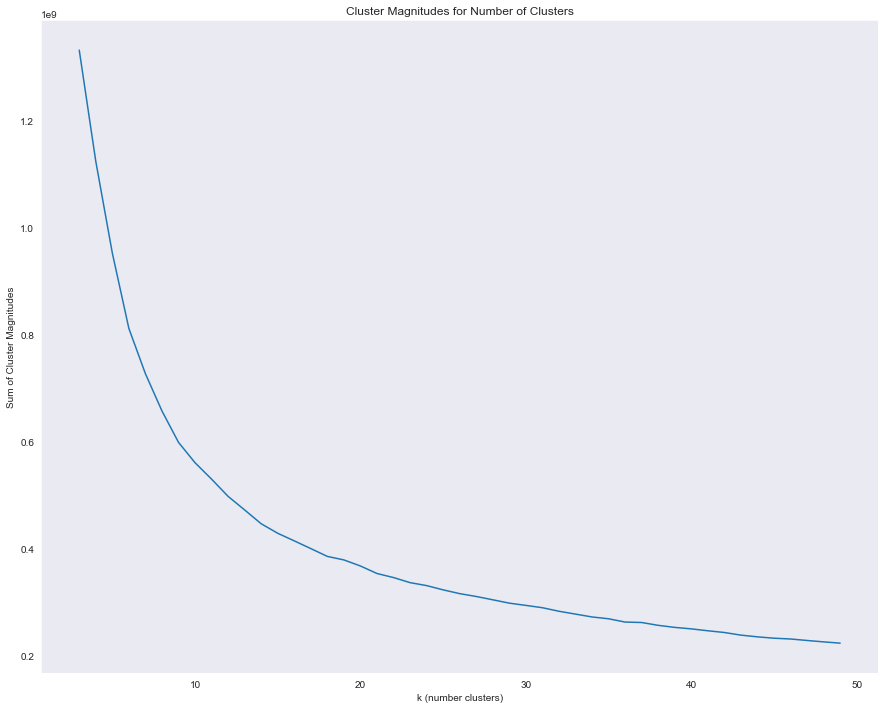

In [6]:
# .inertia_ returns the sum of squared distances of samples to their closest cluster center
# .cluster_centers_  returns array wuth coordinates of cluster centers
# .labels_ returns the cluster label of each example in order

cluster_magn = pd.DataFrame(index=range(3, MAX_K), columns=["Magnitude"])

for k in cluster_magn.index:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(dfp)
    clusters = kmeans.labels_
    cluster_magn["Magnitude"][k] = kmeans.inertia_
    
    cluster_sizes = []
    for i in range(k):
        cluster_sizes.append(len(np.where(clusters == i)[0]))
    
    print("\nk = ", k, "\nCluster Magnitude = ", kmeans.inertia_, "\nCluster Sizes = ", cluster_sizes)
    
plt.figure(figsize=(15, 12))
plt.plot(cluster_magn)
plt.xlabel("k (number clusters)")
plt.ylabel("Sum of Cluster Magnitudes")
plt.title("Cluster Magnitudes for Number of Clusters")

In [10]:
# Choosing k=12 because this is the apparent point where increasing clusters only has marginal benefits
# Research paper suggests using a k that results in small groups
kmeans = KMeans(n_clusters=15, random_state=0).fit(dfp)

df_stats = pd.DataFrame()

dfp["peak_load"] = dfp.max(axis=1)
dfp["profile_cluster"] = kmeans.labels_
dfp["cluster_peak"] = dfp.groupby("profile_cluster")["peak_load"].transform(np.max)

df_stats = dfp[["peak_load", "profile_cluster", "cluster_peak"]]
dfp.drop(["peak_load", "profile_cluster", "cluster_peak"], axis=1, inplace=True)

df_stats

hour,peak_load,profile_cluster,cluster_peak
date,,,
2015-07-02,3363,14,3660
2015-07-03,3445,14,3660
2015-07-04,3223,8,3755
2015-07-05,2901,7,3262
2015-07-06,3158,3,3379
...,...,...,...
2020-06-27,3190,7,3262
2020-06-28,2282,6,2589
2020-06-29,2399,12,2811


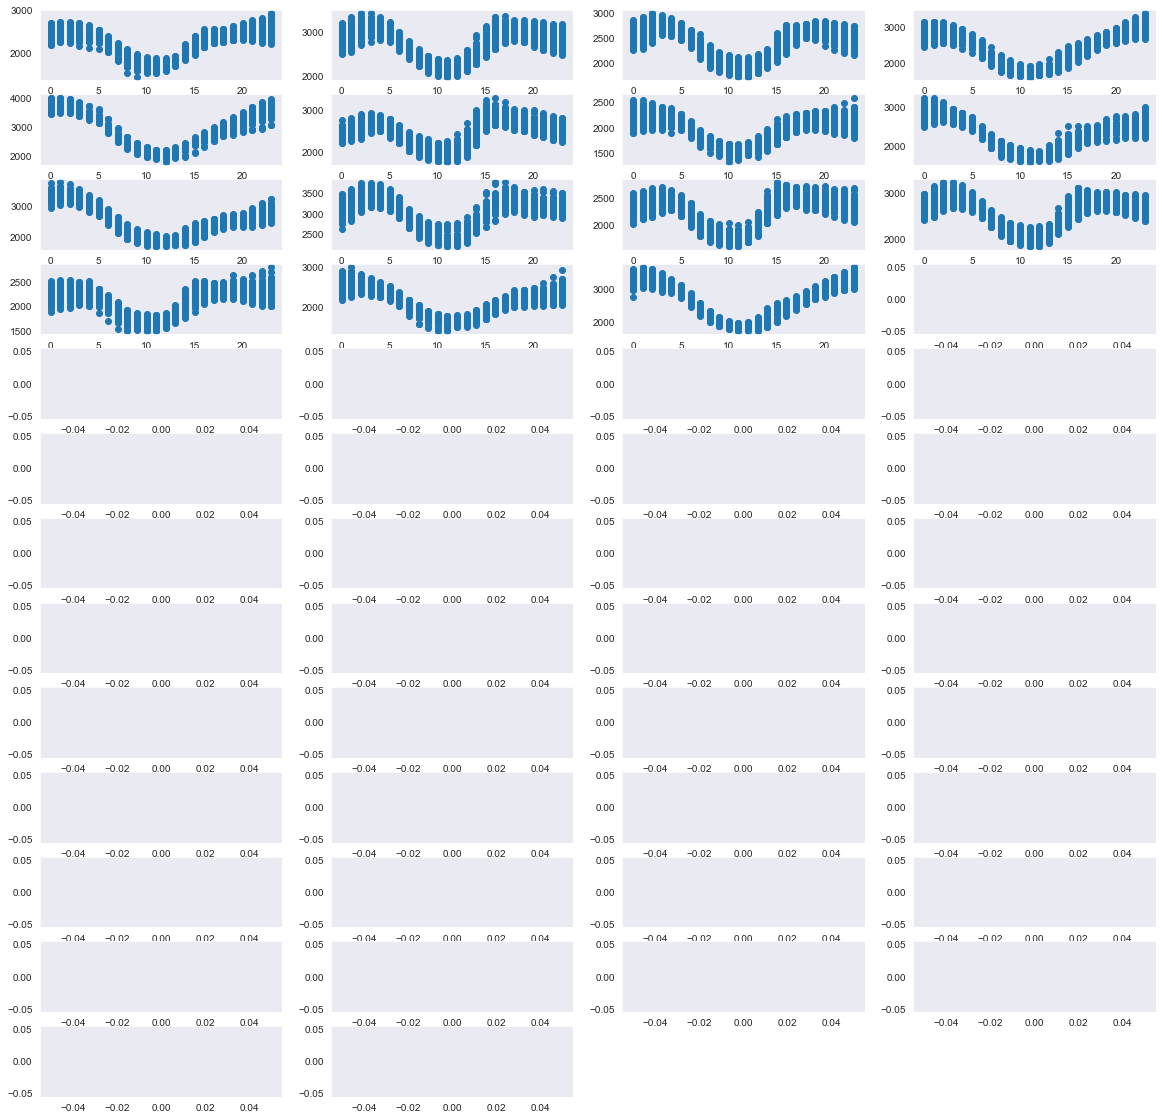

In [12]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)

for k in range(MAX_K):
    dfri = dfp.loc[df_stats["profile_cluster"] == k].reset_index()
    dfrim = dfri.melt(id_vars="date")
    fig.add_subplot(gs[k]).scatter(dfrim["hour"], dfrim["value"])

C:\Users\Jagibbo\AppData\Local\Temp\ipykernel_19244\2775973567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpri_k.drop("clusters", axis=1, inplace=True)
C:\Users\Jagibbo\AppData\Local\Temp\ipykernel_19244\2775973567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpri_k.drop("clusters", axis=1, inplace=True)
C:\Users\Jagibbo\AppData\Local\Temp\ipykernel_19244\2775973567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

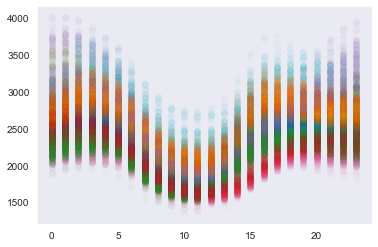

In [13]:
dfpri = dfp.reset_index()
dfpri["clusters"] = kmeans.labels_


for k in range(MAX_K):
    dfpri_k = dfpri.loc[dfpri["clusters"] == k]
    dfpri_k.drop("clusters", axis=1, inplace=True)
    dfprim_k = dfpri_k.melt(id_vars="date")
    plt.scatter(x = dfprim_k["hour"], y = dfprim_k["value"], alpha=0.03)

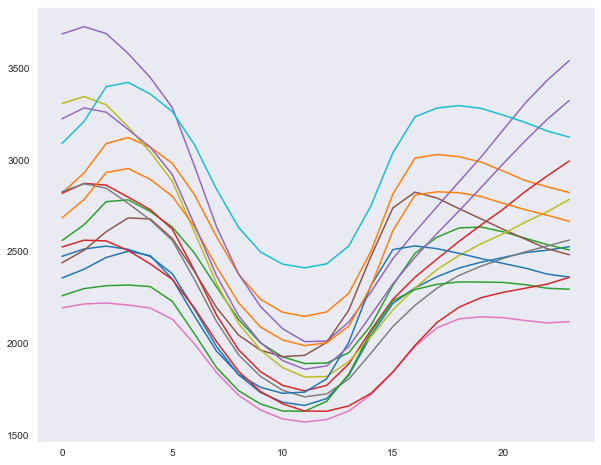

In [14]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids = centroids.T

plt.figure(figsize=(10,8))
plt.plot(centroids[0:24])

Let's figure out what kind of day each cluster represents.

In [15]:
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)"], axis=1)
df_date = df_dropped.pivot(index = "date", columns = "hour", values = ["cleaned demand (MW)", "date_time"])
df_date.columns

for i in range(1, 24):
    df_date.drop(('date_time', i), axis=1, inplace=True)
df_date.columns

MultiIndex([('cleaned demand (MW)',  0),
            ('cleaned demand (MW)',  1),
            ('cleaned demand (MW)',  2),
            ('cleaned demand (MW)',  3),
            ('cleaned demand (MW)',  4),
            ('cleaned demand (MW)',  5),
            ('cleaned demand (MW)',  6),
            ('cleaned demand (MW)',  7),
            ('cleaned demand (MW)',  8),
            ('cleaned demand (MW)',  9),
            ('cleaned demand (MW)', 10),
            ('cleaned demand (MW)', 11),
            ('cleaned demand (MW)', 12),
            ('cleaned demand (MW)', 13),
            ('cleaned demand (MW)', 14),
            ('cleaned demand (MW)', 15),
            ('cleaned demand (MW)', 16),
            ('cleaned demand (MW)', 17),
            ('cleaned demand (MW)', 18),
            ('cleaned demand (MW)', 19),
            ('cleaned demand (MW)', 20),
            ('cleaned demand (MW)', 21),
            ('cleaned demand (MW)', 22),
            ('cleaned demand (MW)', 23),
            (   

In [16]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
df_date["weekday"] = df_date[("date_time", 0)].dt.dayofweek
df_date["season"] = df_date[("date_time", 0)].dt.month%12 // 3 + 1
df_date["cluster"] = kmeans.labels_

df_clusters = df_date[["cluster", "weekday", "season"]]
df_clusters.columns = ["cluster", "weekday", "season"]

for k in range(MAX_K):
    dfk = df_clusters.loc[df_clusters["cluster"] == k]
    print(dfk.value_counts())

cluster  weekday  season
0        4        4         16
         3        3         14
                  4         13
         4        3         13
         2        3         13
         0        3         13
         1        4         12
                  3         11
         2        4         10
         0        4          9
         2        2          7
         5        4          7
         4        2          6
         6        1          5
         3        2          4
         1        2          4
         5        1          4
         6        4          3
         0        2          3
         5        2          2
                  3          1
         0        1          1
dtype: int64
cluster  weekday  season
1        1        1         28
         2        1         22
         3        1         22
         0        1         20
         4        1         16
         5        1          8
         2        4          3
         6        1          3
       

In [17]:
def cluster_similarity(x, centroid):
    # input is all rows belonging to a cluster
    total = 0
    
    for row in range(len(x)):
        for hour in range(23):
            total += abs(x[hour][row] - centroid[hour])
    
    return total/len(x)

In [18]:
centroids.columns

RangeIndex(start=0, stop=15, step=1)

In [19]:
dfp

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,2740,3287,3264,3192,3136,2974,2773,2515,2271,2121,...,2232,2421,2602,2763,2900,3026,3161,3191,3306,3363
2015-07-03,3445,3443,3410,3308,3225,3072,2807,2567,2329,2137,...,2038,2196,2349,2509,2650,2797,2892,2935,3024,3116
2015-07-04,3177,3169,3223,3093,3040,2926,2748,2485,2254,2080,...,1903,1996,2136,2276,2414,2568,2669,2720,2795,2853
2015-07-05,2852,2901,2870,2780,2690,2589,2473,2275,2127,1971,...,1780,1877,2041,2115,2320,2407,2510,2642,2702,2769
2015-07-06,2832,2880,2942,2842,2850,2702,2527,2301,2073,1933,...,2099,2247,2392,2598,2712,2839,2950,3026,3145,3158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,3145,3190,3111,2959,2790,2673,2491,2274,2061,1909,...,1763,1865,1978,2091,2145,2196,2221,2230,2227,2216
2020-06-28,2244,2282,2257,2200,2144,2122,2028,1879,1737,1662,...,1618,1703,1835,1946,2033,2077,2113,2129,2118,2105
2020-06-29,2152,2220,2250,2224,2184,2153,2035,1868,1737,1650,...,1914,2070,2175,2241,2297,2329,2358,2358,2376,2399


In [20]:
cluster_sims = []
for k in range(MAX_K - 1):    
    input_x = dfp.loc[kmeans.labels_ == k].reset_index()
    cluster_sims.append(cluster_similarity(input_x, centroids[k]))
    print(f"\nCluster {k}:", cluster_sims[k])


Cluster 0: 1456.1756437878316

Cluster 1: 2014.4361042524029

Cluster 2: 1797.0536882807855

Cluster 3: 1728.1392028554405

Cluster 4: 2137.934258582909

Cluster 5: 2021.14939413265

Cluster 6: 1375.3209379351865

Cluster 7: 1920.5739584845483

Cluster 8: 2193.5955856176583

Cluster 9: 2735.3856332703263

Cluster 10: 1555.43914677121

Cluster 11: 1744.4896885813173

Cluster 12: 1394.645862764074

Cluster 13: 1645.3046647230287

Cluster 14: 1912.0687603305755


KeyError: 15

(array([1., 5., 6., 4., 8., 9., 2., 6., 2., 1., 3., 0., 1., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([23151.59410431, 24739.30282885, 26327.01155338, 27914.72027792,
        29502.42900245, 31090.13772699, 32677.84645153, 34265.55517606,
        35853.2639006 , 37440.97262514, 39028.68134967, 40616.39007421,
        42204.09879875, 43791.80752328, 45379.51624782, 46967.22497236,
        48554.93369689, 50142.64242143, 51730.35114597, 53318.0598705 ,
        54905.76859504]),
 <BarContainer object of 20 artists>)

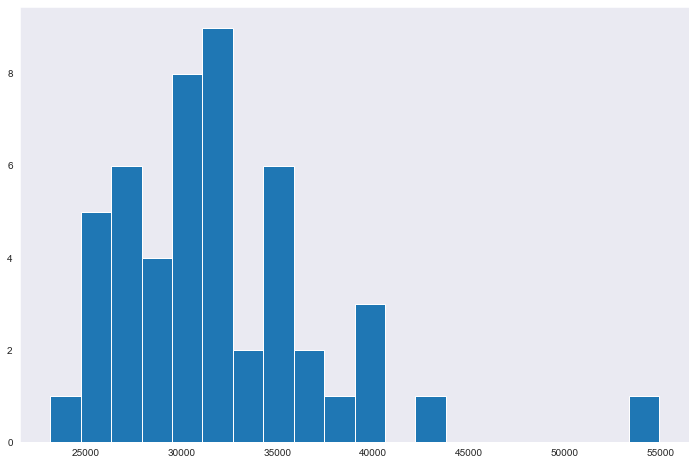

time: 303 ms


In [ ]:
plt.figure(figsize = (12, 8))
plt.hist(cluster_sims, bins = 20)

In [21]:
dset = df_clusters
dset["date_time"] = df_date[("date_time", 0)]
dset["year"] = dset["date_time"].dt.year
dset["day"] = dset["date_time"].dt.dayofyear
dset = dset.reset_index()
dset = dset.melt(id_vars=["year", "day"])
dset = dset.loc[dset["variable"] == "cluster"]
dset.drop("variable", axis=1, inplace=True)
dset.rename(columns = {"value":"cluster"}, inplace=True)
dset = dset.pivot(index="year", columns="day", values="cluster")
dset

C:\Users\Jagibbo\AppData\Local\Temp\ipykernel_19244\2417498832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dset["date_time"] = df_date[("date_time", 0)]
C:\Users\Jagibbo\AppData\Local\Temp\ipykernel_19244\2417498832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dset["year"] = dset["date_time"].dt.year
C:\Users\Jagibbo\AppData\Local\Temp\ipykernel_19244\2417498832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

day,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,2,2,11,1,1,1,1,NaN
2016,1,1,9,9,9,1,1,1,11,2,...,9,1,11,2,11,1,1,1,1,1
2017,11,1,9,9,9,9,9,9,9,9,...,11,1,1,1,9,1,8,7,2,NaN
2018,2,1,1,1,1,2,2,11,11,11,...,2,2,2,5,11,11,2,7,2,NaN
2019,11,1,11,11,2,2,11,1,11,11,...,11,1,2,11,1,2,2,11,11,NaN
2020,7,2,2,2,2,11,11,11,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
# NOTE: Monday = 0
def day_type(season, weekday):
    # Weekdays
    if weekday < 5:
        return season
    # Weekends
    else:
        return season + 4

In [23]:
df_clusters["day type"] = df_clusters["season"]
df_clusters.loc[df_clusters["weekday"] >= 5, "day type"] = 4 + df_clusters["season"]
df_clusters

C:\Users\Jagibbo\AppData\Local\Temp\ipykernel_19244\2155078476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters["day type"] = df_clusters["season"]


,cluster,weekday,season,date_time,year,day,day type
date,,,,,,,
2015-07-02,14,3,3,2015-07-02,2015,183,3
2015-07-03,14,4,3,2015-07-03,2015,184,3
2015-07-04,8,5,3,2015-07-04,2015,185,7
2015-07-05,7,6,3,2015-07-05,2015,186,7
2015-07-06,3,0,3,2015-07-06,2015,187,3
...,...,...,...,...,...,...,...
2020-06-27,7,5,3,2020-06-27,2020,179,7
2020-06-28,6,6,3,2020-06-28,2020,180,7
2020-06-29,12,0,3,2020-06-29,2020,181,3


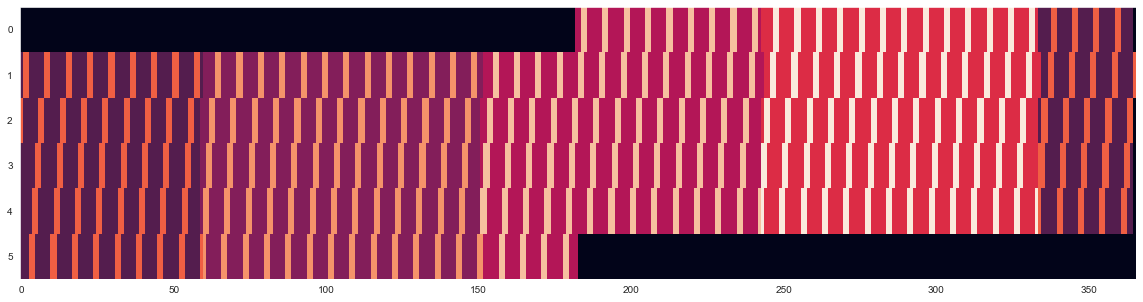

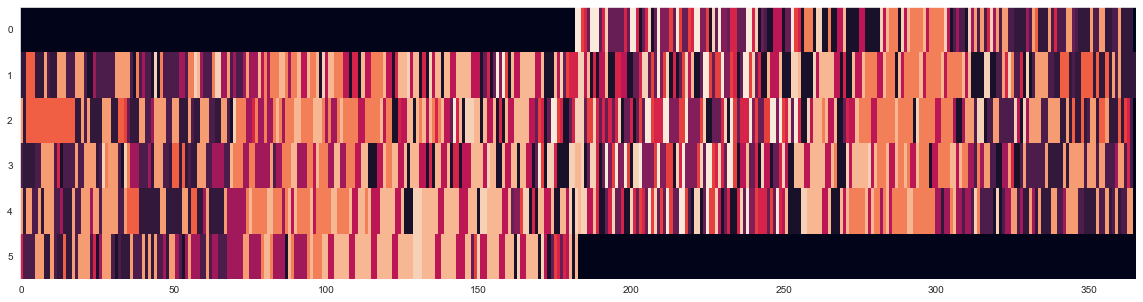

In [24]:
day_type = df_clusters[["day type", "year", "day"]]
day_type = day_type.pivot(index = "year", columns = "day", values = "day type")
day_type.fillna(-1, inplace=True)

plt.figure(figsize=(20, 5))
plt.imshow(day_type, aspect='auto')

dset.fillna(-1, inplace=True)
plt.figure(figsize=(20, 5))
plt.imshow(dset, aspect='auto')